<a href="https://colab.research.google.com/github/Manikandankp/MyFirstRepo/blob/master/Sentinel1_detect_Changes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import ee
 
# Trigger the authentication flow.
ee.Authenticate()
 
# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=1WLCJyYqjnVQpqTRUvvdcxCYBfL0HR-BpsS8A3bpfjw&tc=GU1OPhQrb5imQJx18GsxcfOtJEKoa_y2HpdZbP1Z_wk&cc=6cUkZ9dIrfFTkXXB_MYxBypvAoDCVnOBnZ0aO83xN48

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWj8CLUdqh7tJ9CR2QvIyv5KJ8_uWFqE_c3TZ7_Ti74wj2pNGkd72A0

Successfully saved authorization token.


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, gamma, f, chi2
import IPython.display as disp
%matplotlib inline

In [4]:
# Import the Folium library.
import folium

# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [5]:
geoJSON = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              8.473892211914062,
              49.98081240937428
            ],
            [
              8.658599853515625,
              49.98081240937428
            ],
            [
              8.658599853515625,
              50.06066538593667
            ],
            [
              8.473892211914062,
              50.06066538593667
            ],
            [
              8.473892211914062,
              49.98081240937428
            ]
          ]
        ]
      }
    }
  ]
}

In [6]:
coords = geoJSON['features'][0]['geometry']['coordinates']
aoi = ee.Geometry.Polygon(coords)

In [7]:
ffa_db = ee.Image(ee.ImageCollection('COPERNICUS/S1_GRD') 
                       .filterBounds(aoi) 
                       .filterDate(ee.Date('2020-08-01'), ee.Date('2020-08-31')) 
                       .first() 
                       .clip(aoi))
ffa_fl = ee.Image(ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT') 
                       .filterBounds(aoi) 
                       .filterDate(ee.Date('2020-08-01'), ee.Date('2020-08-31')) 
                       .first() 
                       .clip(aoi))

In [8]:
ffa_db.bandNames().getInfo()

['VV', 'VH', 'angle']

In [9]:
url = ffa_db.select('VV').getThumbURL({'min': -20, 'max': 0})
disp.Image(url=url, width=800)

In [10]:
location = aoi.centroid().coordinates().getInfo()[::-1]

# Make an RGB color composite image (VV,VH,VV/VH).
rgb = ee.Image.rgb(ffa_db.select('VV'),
                   ffa_db.select('VH'),
                   ffa_db.select('VV').divide(ffa_db.select('VH')))

# Create the map object.
m = folium.Map(location=location, zoom_start=12)

# Add the S1 rgb composite to the map object.
m.add_ee_layer(rgb, {'min': [-20, -20, 0], 'max': [0, 0, 2]}, 'FFA')

# Add a layer control panel to the map.
m.add_child(folium.LayerControl())

# Display the map.
display(m)

In [11]:
geoJSON = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              8.534317016601562,
              50.021637833966786
            ],
            [
              8.530540466308594,
              49.99780882512238
            ],
            [
              8.564186096191406,
              50.00663576154257
            ],
            [
              8.578605651855469,
              50.019431940583104
            ],
            [
              8.534317016601562,
              50.021637833966786
            ]
          ]
        ]
      }
    }
  ]
}
coords = geoJSON['features'][0]['geometry']['coordinates']
aoi_sub = ee.Geometry.Polygon(coords)

In [12]:
hist = ffa_fl.select('VV').reduceRegion(
    ee.Reducer.fixedHistogram(0, 0.5, 500),aoi_sub).get('VV').getInfo()
mean = ffa_fl.select('VV').reduceRegion(
    ee.Reducer.mean(), aoi_sub).get('VV').getInfo()
variance = ffa_fl.select('VV').reduceRegion(
    ee.Reducer.variance(), aoi_sub).get('VV').getInfo()

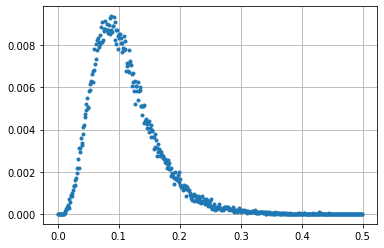

In [13]:
a = np.array(hist)
x = a[:, 0]                 # array of bucket edge positions
y = a[:, 1]/np.sum(a[:, 1]) # normalized array of bucket contents
plt.grid()
plt.plot(x, y, '.')
plt.show()

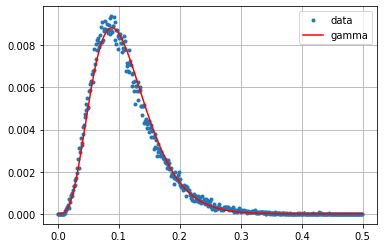

In [14]:
alpha = 5
beta = mean/alpha
plt.grid()
plt.plot(x, y, '.', label='data')
plt.plot(x, gamma.pdf(x, alpha, 0, beta)/1000, '-r', label='gamma')
plt.legend()
plt.show()

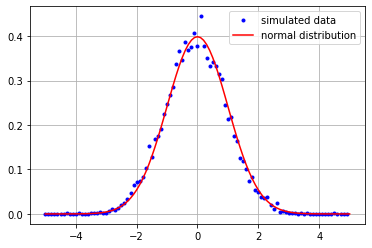

In [15]:
def X(n):
    return np.sum(np.cos(4*np.pi*(np.random.rand(n)-0.5)))/np.sqrt(n/2)

n= 10000
Xs = [X(n) for i in range(10000)]
y, x = np.histogram(Xs, 100, range=[-5,5])
plt.plot(x[:-1], y/1000, 'b.', label='simulated data')
plt.plot(x, norm.pdf(x), '-r', label='normal distribution')
plt.grid()
plt.legend()
plt.show()

In [16]:
mean ** 2 / variance

4.324058395540761

In [17]:
geoJSON = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              8.473892211914062,
              49.98081240937428
            ],
            [
              8.658599853515625,
              49.98081240937428
            ],
            [
              8.658599853515625,
              50.06066538593667
            ],
            [
              8.473892211914062,
              50.06066538593667
            ],
            [
              8.473892211914062,
              49.98081240937428
            ]
          ]
        ]
      }
    }
  ]
}
coords = geoJSON['features'][0]['geometry']['coordinates']
aoi = ee.Geometry.Polygon(coords)
geoJSON = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              8.534317016601562,
              50.021637833966786
            ],
            [
              8.530540466308594,
              49.99780882512238
            ],
            [
              8.564186096191406,
              50.00663576154257
            ],
            [
              8.578605651855469,
              50.019431940583104
            ],
            [
              8.534317016601562,
              50.021637833966786
            ]
          ]
        ]
      }
    }
  ]
}
coords = geoJSON['features'][0]['geometry']['coordinates']
aoi_sub = ee.Geometry.Polygon(coords)

In [18]:
im_coll = (ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT')
                .filterBounds(aoi)
                .filterDate(ee.Date('2020-08-01'),ee.Date('2020-08-31'))
                .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
                .filter(ee.Filter.eq('relativeOrbitNumber_start', 15))
                .sort('system:time_start'))

In [19]:
import time
acq_times = im_coll.aggregate_array('system:time_start').getInfo()
[time.strftime('%x', time.gmtime(acq_time/1000)) for acq_time in acq_times]

['08/05/20', '08/11/20', '08/17/20', '08/23/20', '08/29/20']

In [20]:
im_list = im_coll.toList(im_coll.size())
im1 = ee.Image(im_list.get(0)).select('VV').clip(aoi_sub)
im2 = ee.Image(im_list.get(1)).select('VV').clip(aoi_sub)

In [21]:
ratio = im1.divide(im2)
url = ratio.getThumbURL({'min': 0, 'max': 10})
disp.Image(url=url, width=800)

In [22]:
hist = ratio.reduceRegion(ee.Reducer.fixedHistogram(0, 5, 500), aoi_sub).get('VV').getInfo()
mean = ratio.reduceRegion(ee.Reducer.mean(), aoi_sub).get('VV').getInfo()
variance = ratio.reduceRegion(ee.Reducer.variance(), aoi_sub).get('VV').getInfo()

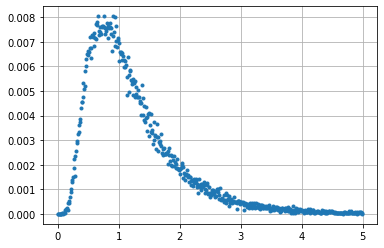

In [23]:
a = np.array(hist)
x = a[:, 0]
y = a[:, 1] / np.sum(a[:, 1])
plt.grid()
plt.plot(x, y, '.')
plt.show()

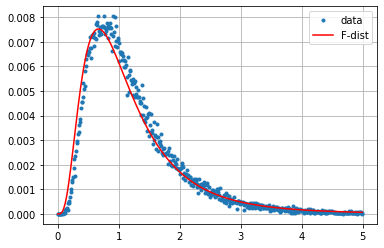

In [24]:
m = 5
plt.grid()
plt.plot(x, y, '.', label='data')
plt.plot(x, f.pdf(x, 2*m, 2*m) / 100, '-r', label='F-dist')
plt.legend()
plt.show()

In [25]:
print(mean, m/(m-1))
print(variance, m*(2*m-1)/(m-1)**2/(m-2))

1.2474381628341111 1.25
0.6996603895144189 0.9375


In [26]:
im1 = ee.Image(im_list.get(0)).select('VV').clip(aoi)
im2 = ee.Image(im_list.get(1)).select('VV').clip(aoi)
ratio = im1.divide(im2)

location = aoi.centroid().coordinates().getInfo()[::-1]
mp = folium.Map(location=location, zoom_start=12)
mp.add_ee_layer(ratio,
                {'min': 0, 'max': 20, 'palette': ['black', 'white']}, 'Ratio')
mp.add_child(folium.LayerControl())

display(mp)

In [27]:
# Decision threshold alpha/2:
dt = f.ppf(0.0005, 2*m, 2*m)

# LRT statistics.
q1 = im1.divide(im2)
q2 = im2.divide(im1)

# Change map with 0 = no change, 1 = decrease, 2 = increase in intensity.
c_map = im1.multiply(0).where(q2.lt(dt), 1)
c_map = c_map.where(q1.lt(dt), 2)

# Mask no-change pixels.
c_map = c_map.updateMask(c_map.gt(0))

# Display map with red for increase and blue for decrease in intensity.
location = aoi.centroid().coordinates().getInfo()[::-1]
mp = folium.Map(
    location=location, tiles='Stamen Toner',
    zoom_start=13)
folium.TileLayer('OpenStreetMap').add_to(mp)
mp.add_ee_layer(ratio,
                {'min': 0, 'max': 20, 'palette': ['black', 'white']}, 'Ratio')
mp.add_ee_layer(c_map,
                {'min': 0, 'max': 2, 'palette': ['black', 'blue', 'red']},
                'Change Map')
mp.add_child(folium.LayerControl())

display(mp)

In [28]:
def det(im):
  return im.expression('b(0) * b(1)')

# Number of looks.
m = 5

im1 = ee.Image(im_list.get(0)).select('VV', 'VH').clip(aoi)
im2 = ee.Image(im_list.get(1)).select('VV', 'VH').clip(aoi)

m2logQ = det(im1).log().add(det(im2).log()).subtract(
    det(im1.add(im2)).log().multiply(2)).add(4*np.log(2)).multiply(-2*m)

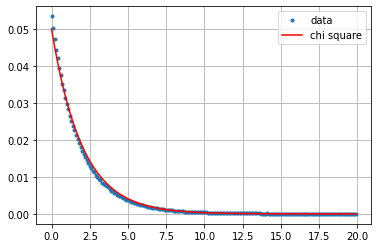

In [29]:
hist = m2logQ.reduceRegion(
    ee.Reducer.fixedHistogram(0, 20, 200), aoi).get('VV').getInfo()
a = np.array(hist)
x = a[:, 0]
y = a[:, 1] / np.sum(a[:, 1])
plt.plot(x, y, '.', label='data')
plt.plot(x, chi2.pdf(x, 2)/10, '-r', label='chi square')
plt.legend()
plt.grid()
plt.show()

In [30]:
geoJSON ={
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -98.2122802734375,
              49.769291532628515
            ],
            [
              -98.00559997558594,
              49.769291532628515
            ],
            [
              -98.00559997558594,
              49.88578690918283
            ],
            [
              -98.2122802734375,
              49.88578690918283
            ],
            [
              -98.2122802734375,
              49.769291532628515
            ]
          ]
        ]
      }
    }
  ]
}
coords = geoJSON['features'][0]['geometry']['coordinates']
aoi1 = ee.Geometry.Polygon(coords)

In [31]:
im1 = ee.Image(ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT')
                .filterBounds(aoi1)
                .filterDate(ee.Date('2018-08-01'), ee.Date('2018-08-31'))
                .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
                .filter(ee.Filter.eq('relativeOrbitNumber_start', 136))
                .first()
                .clip(aoi1))
im2 = ee.Image(ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT').filterBounds(aoi1)
                .filterDate(ee.Date('2018-09-01'), ee.Date('2018-09-30'))
                .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
                .filter(ee.Filter.eq('relativeOrbitNumber_start', 136))
                .first()
                .clip(aoi1))

In [32]:
acq_time = im1.get('system:time_start').getInfo()
print( time.strftime('%x', time.gmtime(acq_time/1000)) )
acq_time = im2.get('system:time_start').getInfo()
print( time.strftime('%x', time.gmtime(acq_time/1000)) )

08/01/18
09/06/18


In [34]:
def chi2cdf(chi2, df):
  ''' Chi square cumulative distribution function for df degrees of freedom
      using the built-in incomplete gamma function gammainc() '''
  return ee.Image(chi2.divide(2)).gammainc(ee.Number(df).divide(2))

# The observed test statistic image -2logq.
m2logq = det(im1).log().add(det(im2).log()).subtract(
    det(im1.add(im2)).log().multiply(2)).add(4*np.log(2)).multiply(-2*m)

# The P value image prob(m2logQ > m2logq) = 1 - prob(m2logQ < m2logq).
p_value = ee.Image.constant(1).subtract(chi2cdf(m2logq, 2))

# Project onto map.
location = aoi1.centroid().coordinates().getInfo()[::-1]
mp = folium.Map(location=location, zoom_start=12)
mp.add_ee_layer(p_value,
                {'min': 0,'max': 1, 'palette': ['black', 'white']}, 'P-value')
mp.add_child(folium.LayerControl())

In [35]:
c_map = p_value.multiply(0).where(p_value.lt(0.01), 1)

crop2018 = (ee.ImageCollection('AAFC/ACI')
             .filter(ee.Filter.date('2018-01-01', '2018-12-01'))
             .first()
             .clip(aoi1))

mp = folium.Map(location=location, zoom_start=12)
mp.add_ee_layer(crop2018, {min: 0, max: 255}, 'crop2018')
mp.add_ee_layer(c_map.updateMask(
    c_map.gt(0)), {'min': 0, 'max': 1, 'palette': ['black', 'red']}, 'c_map')
mp.add_child(folium.LayerControl())

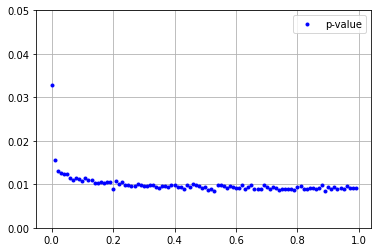

In [36]:
geoJSON ={
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -98.18550109863281,
              49.769735012247885
            ],
            [
              -98.13949584960938,
              49.769735012247885
            ],
            [
              -98.13949584960938,
              49.798109268622
            ],
            [
              -98.18550109863281,
              49.798109268622
            ],
            [
              -98.18550109863281,
              49.769735012247885
            ]
          ]
        ]
      }
    }
  ]
}
coords = geoJSON['features'][0]['geometry']['coordinates']
aoi1_sub = ee.Geometry.Polygon(coords)
hist = p_value.reduceRegion(ee.Reducer.fixedHistogram(0, 1, 100), aoi1_sub).get('constant').getInfo()
a = np.array(hist)
x = a[:,0]
y = a[:,1]/np.sum(a[:,1])
plt.plot(x, y, '.b', label='p-value')
plt.ylim(0, 0.05)
plt.grid()
plt.legend()
plt.show()

In [37]:
c_map = p_value.multiply(0).where(p_value.lt(0.01), 1)
diff = im2.subtract(im1)
d_map = c_map.multiply(0)                    # Initialize the direction map to zero.
d_map = d_map.where(det(diff).gt(0), 2)      # All pos or neg def diffs are now labeled 2.
d_map = d_map.where(diff.select(0).gt(0), 3) # Re-label pos def (and label some indef) to 3.
d_map = d_map.where(det(diff).lt(0), 1)      # Label all indef to 1.
c_map = c_map.multiply(d_map)                # Re-label the c_map, 0*X = 0, 1*1 = 1, 1*2= 2, 1*3 = 3.

In [38]:
mp = folium.Map(location=location, zoom_start=12)
mp.add_ee_layer(crop2018, {min: 0, max: 255}, 'crop2018')
mp.add_ee_layer(
    c_map.updateMask(c_map.gt(0)), {
        'min': 0,
        'max': 3,
        'palette': ['black', 'yellow', 'blue', 'red']
    }, 'c_map')
mp.add_child(folium.LayerControl())